In [76]:
from scipy.optimize import linear_sum_assignment
from sklearn.utils import resample
import numpy as np
from collections.abc import Iterable
from typing import Callable, TypeVar
import pylab

# Wasserstein metrics


### Overview of defintions

Following [1], the Wasserstein metric can be defined on a suitably nice metric space $(M, d)$ (where 'suitably nice' means a space homeomorphic to a complete metric space that has a countable dense subset) as a metric on a pair of probability distributions $\mu$ and $\nu$ on $M$:

$W_p(\mu, \nu) = \inf_{\gamma \in \Gamma(\mu, \nu)} \left(\mathbf{E}_{(x, y) \sim \gamma} d(x, y)^p \right)^{1/p}$

where $\Gamma(\mu, \nu)$ is the set of all couplings between $\mu$ and $\nu$. Following [3], $W_p$ is a metric on the space of probability distributions on $M$. 

$W_p$ can be thought of as an optimal transport problem, where one is trying to move the 'distribution mass' from $\mu$ to $\nu$ with minimal effort (where effort is moving a chunk of the probability density from $x$ to $y$ over a distance $d(x,y)$). [2] shows how to calculate $W_p$ in a number of different cases. [4] shows, in detail, how to generally calculate $W_2$ for an empirical distribution.

Taking $\mu$ and $\nu$ to be empirical distributions with samples $\{X_i\}$ and $\{Y_i\}$ respectively, each with $n$ samples, $W_p$ becomes:

$W_p(\mu, \nu) = \inf_\pi \left( \frac{1}{n} \sum_{i=1}^n d(X_i, Y_{\pi(i)})^p \right)^{1/p}$

where the infimum is over all permutations $\pi$ of $n$ elements.

### Direct calculation for empirical distributions

The real work is working out the permutation $\pi_0$ that yields the infimum.

$\pi_0  = \arg\min_{\pi} \left( \frac{1}{n} \sum_{i=1}^n d(X_i, Y_{\pi(i)})^p \right)^{1/p}
= \arg\min_{\pi} \left(\sum_{i=1}^n d(X_i, Y_{\pi(i)})^p \right)$

This can be recast as a linear sum assignment problem

$\pi_0 = \arg\min_{\pi} \left(\sum_{i=1}^n d(X_i, Y_{\pi(i)})^p \right)
= \arg\min_{\pi} \left(\sum_{i=1}^n \sum_{j=1}^n d(X_i, Y_j)^p \delta_{\pi(i), j}\right) $

where in [5], the cost matrix $C_{i,j} = d(X_i, Y_j)^p$, and the boolean assignment matrix $X_{i,j} = \delta_{\pi(i), j}$.

Once $\pi_0$ is known, calculation of the empirical $W_p$ becomes straightforward

$W_p(\mu, \nu) = \left( \frac{1}{n} \sum_{i=1}^n d(X_i, Y_{\pi_0(i)})^p \right)^{1/p}$



In [41]:
Sample = TypeVar("Sample")

def get_optimal_permutation(
    samples_x: Iterable[Sample], 
    samples_y: Iterable[Sample], 
    wasserstein_p: float, 
    distance_fn: Callable[[Sample, Sample], float]
) -> Iterable[int]:
    """ takes a pair of (equal length) sample lists, computes the Wasserstein cost function, and
        returns an array describing the optimal permutation to apply on the second list of samples
        to us in computation of a Wasserstein distance.
    """
    if len(samples_x) != len(samples_y):
        raise ValueError(f"input sample lengths {len(samples_x)}, {len(samples_y)} differ")
    n_samples = len(samples_x)
    cost_matrix = np.zeros((n_samples, n_samples))
    for ctr_i in range(n_samples):
        for ctr_j in range(n_samples):
            cost_matrix[ctr_i, ctr_j] = distance_fn(samples_x[ctr_i], samples_y[ctr_j]) ** wasserstein_p
    _, permutation = linear_sum_assignment(cost_matrix)
    return permutation

As an example, consider a pair of sample sets on the real line with an L1 norm (i.e. $M=\mathbb{R}$, $d = |.|_1$). For simplicity and pedagogy, consider samples which we can see how to re-order.

In [42]:
simple_x = [1, 2, 3, 4]
simple_y = [1.1, 3.1, 4.1, 2.1]
real_line_l1_distance = lambda x, y: np.abs(x-y)
simple_p = 1

permutations = get_optimal_permutation(simple_x, simple_y, simple_p, real_line_l1_distance)
print(permutations)

[0 3 1 2]


The indexes above show the target index of where the indexes of the Y samples should be mapped to

In [43]:
print(simple_x)
print([simple_y[p] for p in permutations])

[1, 2, 3, 4]
[1.1, 2.1, 3.1, 4.1]


Given the optimal permutation, the Wasserstein distance can then be calculated directly

In [48]:
def get_wasserstein_distance_from_permutation(
    samples_x: Iterable[Sample], 
    samples_y: Iterable[Sample], 
    wasserstein_p: float, 
    distance_fn: Callable[[Sample, Sample], float],
    permutations: Iterable[int]
) -> float:
    if len(samples_x) != len(samples_y):
        raise ValueError(f"input sample lengths {len(samples_x)}, {len(samples_y)} differ")
    n_samples = len(samples_x)

    permuted_y = [samples_y[p] for p in permutations]
    wasserstein_distance = sum([distance_fn(x, y) ** wasserstein_p for x, y in zip(samples_x, permuted_y)])
    wasserstein_distance /= n_samples
    wasserstein_distance = wasserstein_distance ** 1 / wasserstein_p
    return wasserstein_distance

In [49]:
get_wasserstein_distance_from_permutation(simple_x, simple_y, simple_p, real_line_l1_distance, permutations)

0.09999999999999998

The examples above assume that the number of samples for X and Y are the same. In general, this need not be the case. On the assumption that both samples give good coverage of the underlying distributions, it might be preferable to upsample the smaller set than down sample the larger set. The upsample should also try to preserve the original distribution of samples as much as possible without skewing them.

In [70]:
def get_resampled_sample_sets(
    samples_x: Iterable[Sample], 
    samples_y: Iterable[Sample]
) -> (Iterable[Sample], Iterable[Sample]):
    n_samples = max(len(samples_x), len(samples_y))
    is_x_smaller = len(samples_x) < len(samples_y)
    samples = samples_x if is_x_smaller else samples_y
    scale_factor = n_samples / len(samples)
    np_samples = np.copy(samples)
    for _ in range(1, int(scale_factor)):  # take direct whole copies to fill up samples
        np_samples = np.concatenate((np_samples, samples))
    if (n_samples - len(np_samples)):
        np_samples = np.concatenate(  # add in a few more random samples to top up the smaller set
            (np_samples, resample(samples, replace=False, n_samples=n_samples - len(np_samples)))
        )                          
    if is_x_smaller:
        samples_x = np_samples
    else:
        samples_y = np_samples
    return samples_x, samples_y

In [71]:
get_resampled_sample_sets([[1.1, 1.1], [3.3, 3.3], [2.2, 2.2], [4.4, 4.4], [5.5, 5.5]], [[1,1], [2,2]])

([[1.1, 1.1], [3.3, 3.3], [2.2, 2.2], [4.4, 4.4], [5.5, 5.5]],
 array([[1, 1],
        [2, 2],
        [1, 1],
        [2, 2],
        [1, 1]]))

From this one can define a Wasserstein distance on all empricial distributions for any integer p > 0

In [72]:
def get_wasserstein_distance(
    samples_x: Iterable[Sample],
    samples_y: Iterable[Sample],
    wasserstein_p: float,
    distance_fn: Callable[[Sample, Sample], float]
) -> float:
    samples_x, samples_y = get_resampled_sample_sets(samples_x, samples_y)
    permutations = get_optimal_permutation(samples_x, samples_y, wasserstein_p, distance_fn)
    return get_wasserstein_distance_from_permutation(samples_x, samples_y, wasserstein_p, distance_fn, permutations)

### Data drift example

As a play example, consider the some normally distributed data that drifts over days.

In [77]:
def get_binned_samples(loc: float, n_sample: int, bin_width: float=0.1, scale: float=1.0) -> dict[float, float]:
    """ loc - centre of normal distribution
        n_sample - number of samples to generate
        bin_width - width of the bins to make the histogram
        scale - standard deviation of normal distribution
        
        returns a dict<bin value, frequency of bin>
    """
    samples = np.random.normal(loc=loc, scale=scale, size=n_sample)
    binned_samples = {}
    for sample in samples:
        bin = int(sample / bin_width) * bin_width
        binned_samples[bin] = binned_samples.get(bin, 0) + 1
    if 0 in binned_samples.keys():
        binned_samples[0] /= 2  # overcounting of zero bin
    return binned_samples

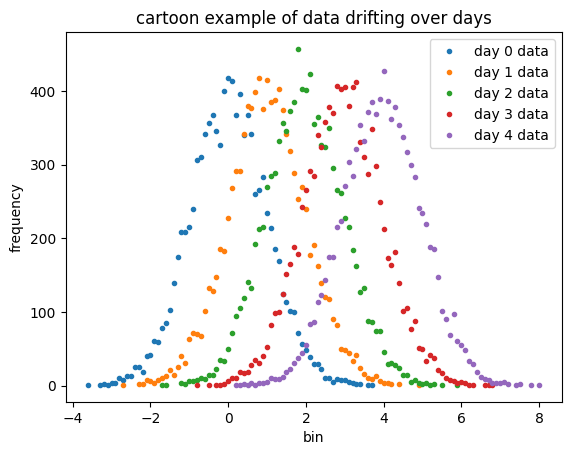

In [78]:
n_sample = 10000
dayN_datas = []
for i_day, loc in enumerate(np.arange(0,5,1.0)):
    this_samples = get_binned_samples(loc, n_sample)
    pylab.plot(this_samples.keys(), this_samples.values(), '.', label=f"day {i_day} data")
    dayN_datas.append(this_samples)
pylab.xlabel("bin")
pylab.ylabel("frequency")
pylab.title("cartoon example of data drifting over days")
_ = pylab.legend()

In [94]:
wasserstein_p = 2
norm_order = 2

distance_fn = lambda x, y: np.linalg.norm(x-y, ord=norm_order)  # L_n norm on R, where n=ord

n_sample = 1000
scale = 1.0

# get samples for the zeroth day
X0 = np.random.normal(loc=0, scale=scale, size=n_sample).reshape((n_sample, 1))
print(f"X0 shape = {X0.shape}")

X0 shape = (1000, 1)


In [95]:
for i_day, loc in enumerate(np.arange(0,5,1.0)):
    # generate data for the drifted day
    X1 = np.random.normal(loc=loc, scale=scale, size=n_sample).reshape((n_sample, 1))
    wasserstein_distance = get_wasserstein_distance(X0, X1, wasserstein_p, distance_fn)
    print(f"Wasserstein distance between day 0 and day {i_day} = {wasserstein_distance}")

Wasserstein distance between day 0 and day 0 = 0.002568556327507177
Wasserstein distance between day 0 and day 1 = 0.5412299552129992
Wasserstein distance between day 0 and day 2 = 2.1070184782271877
Wasserstein distance between day 0 and day 3 = 4.641583938376564
Wasserstein distance between day 0 and day 4 = 8.016440659962255


### References

[1] Wikipedia, "[Wasserstein metric](https://en.wikipedia.org/wiki/Wasserstein_metric)"

[2] Wasserman, L., "[Optimal transport and Wasserstein distance](https://www.stat.cmu.edu/~larry/=sml/Opt.pdf)"

[3] Clement, P., Desch, W., "[An elementary proof of the triangle inequality for the Wasserstein metric](https://math.leidenuniv.nl/reports/files/wasserstein2-7.pdf)"

[4] Williams, A., "[A short introduction to optimal transport and Wasserstein distance](https://alexhwilliams.info/itsneuronalblog/2020/10/09/optimal-transport/)"

[5] Scipy docs, "[scipy.optimize.linear_sum_assignment](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html)"